<a href="https://colab.research.google.com/github/TacticalCoders/NLP-with-Pytorch/blob/main/5_1_Pretrained_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 단어와 타입 임베딩

NLP 작업을 구현할 때는 여러 종류의 이산적인 타입(type)을 다뤄야 한다.

대표적으로 단어가 있다. 단어는 유한한 집합(어휘사전)으로 구성된다. 또한 문자, 품사 태깅, 개체명, 개체명 타입, 파싱 피처, 제품 카탈로그의 아이템도 이산 타입이다.

기본적으로 유한한 집합(또는 가산 무한 집합)에서 얻은 모든 입력 특성은 **이산 타입**이다.

이산 타입(단어)을 **밀집 벡터로 표현**하는 것은 NLP에서 딥러닝 성공의 핵심 열쇠이다. '표현 학습'과 '임베딩'이란 용어는 이산 타입과 벡터 공간의 포인트 사이에 매핑을 학습하는 것을 의미한다. 

이산 타입이 단어일 때 밀집 벡터 표현을 **단어 임베딩(word embedding)**이라 한다. 여기서는 학습 기반 또는 예측 기반의 임베딩 방법을 알아볼 것이다.
(문맥에 기반해 단어를 예측하듯이 특정 학습 작업을 위한 목적 함수를 최대화함으로써 이런 표현을 학습)

단어 임베딩은 NLP 작업에서 많이 사용되며 어떤 NLP 작업에서도 성능 향상을 기대할 수 있다.(NLP의 스리라차라는 별명도 있다.)

이제 단어 임베딩과 관련된 벡터 표현, 단어 임베딩 방법, 지도 학습과 비지도 학습의 언어 작업에서 단어 임베딩을 최적화하는 방법, 문장과 문서에서 단어 임베딩을 연결하는 방법을 아라보자.

## 임베딩을 배우는 이유

4장까지는 단어를 벡터로 표현할 때 원-핫 표현을 사용했다.(어휘 사전의 길이를 가지고, 특정 단어를 나타내는 한 위치만 1이고 나머지는 0이다.)

저차원으로 학습된 밀집 표현은 원-핫 표현이나 카운트 기반 벡터와 다른 장점이 있다.



1.   차원을 줄이면 계산을 효율적으로 수행한다.
2.   카운트 기반 표현은 여러 차원에 비슷한 정보를 중복해 인코딩한 고차원 벡터를 만든다.(통계적 장점 공유 x)
3.   고차원 입력은 머신러닝과 최적화에서 실제로 문제가 될 수 있다. -> 차원의 저주 
4.   작업에 특화된 테이터에서 학습된(or 미세 튜닝된) 표현은 현재 작업에 최적이다.





### 임베딩의 효율성

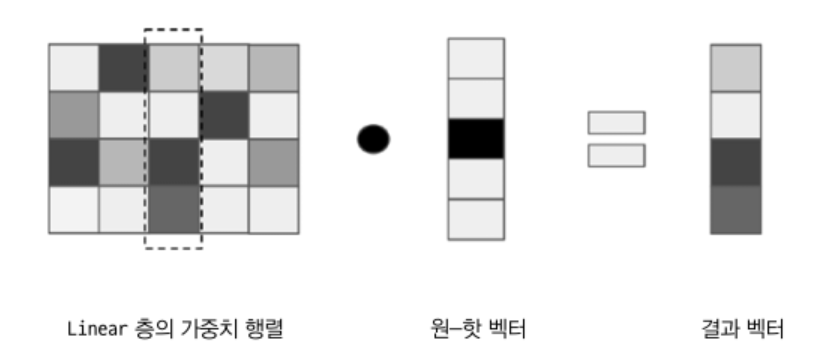

위처럼 원-핫 벡터를 입력으로 받는 Linear 층의 가중치 행렬에는 원-학 벡터의 크기와 같은 개수의 열이 있어야 한다.(입력되는 각 x에 대한 가중치 행렬)

원-핫 벡터는 0과 1로만 이루어져 있으므로 3세째 행이 가리키는 인덱스의 열이 선택되는 것을 볼 수 있다. 즉, **행렬 곱셉 단계를 건너 뛰고**(계산 비용을 엄청나게 줄일 수 있다) 직접 정수를 인덱스로 사용하여 정수를 **인덱스로 선택된 행을 추출**할 수 있다.

위 그림에서는 가중치 행렬과 원-핫 벡터의 차원이 같지만 임베딩은 원-핫 벡터 또는 카운트 기반 표현보다 낮은 차원 공간에서 단어를 표현하는 데 사용된다.(일반적으로 25~500차원, GPU의 메모리양에 따라 선택하면 된다)

### 단어 임베딩 학습 방법

직접 새로운 단어 임베딩 훈련 알고리즘을 만들일은 거의 없다.

하지만 단어 임베딩을 훈련하는 최근 방법을 간략하게 알아볼 것이다. 

단어 임베딩은 모두 단어만으로(레이블이 없는 데이터로) 학습되지만 지도 학습 방식을 사용한다. 이를 위해 데이터가 암묵적으로 레이블되어 있는 보조 작업을 구성한다. 이 보조 작업을 해결하기 위한 최적화된 표현은 텍스트 말뭉치의 많은 **통계적, 언어적** 속성을 감지하여 유용성이 높을 것이다. 다음은 보조 작업의 몇 가지 예이다.



*   단어 시퀀스가 주어지면 다음 단어를 예측한다.(**언어 모델링 작업**)
*   앞과 뒤의 단어 시퀀스가 주어지면 누락된 단어를 예측한다.
*   단어가 주어지면 위치에 관계없이 윈도 안에 등장할 단어를 예측한다.

이 목록은 완전하지 않으며 설계자의 직관과 계산 비용에 따라 달라진다.
(일반적으로는 사전 훈련된 단어 임베딩을 미세 조정해서 사용하기만 해도 충분하다.)


### 사전 훈련된 단어 임베딩

구글 뉴스, 위키피디아, 커먼 크롤과 같은 대규모 말뭉치와 위에서 설명한 여러 방법 중 하나를 사용해 사전 훈련된 단어 임베딩(pretrained word embedding)을 무료로 다운로드해서 사용할 수 있다.

#### 임베딩 로드

단어 임베딩은 널리 보급되었다. 원본 Word2Vec에서 스텐포드의 GLoVe, 페이스북의 FastText 등 많은 변종을 다운로드 할 수 있다.

일반적으로 임베딩은 다음과 같은 포맷으로 제공된다.

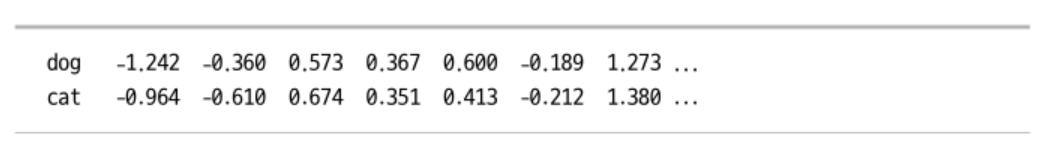

각 줄은 임베딩되는 **단어(타입)으로 시작**하고 그 뒤에**숫자 시퀀스(즉, 벡터** 표현)가 온다. 시퀀스의 길이는 **표현의 차원(임베딩 차원)**이다. 보통 임베딩 차원은 수백 개 정도이다. 토큰 타입의 개수는 어휘 사전의 크기이며 백만 개 정도이다.

In [10]:
# GloVe 데이터를 다운로드합니다.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!mkdir -p data/glove
!mv glove.6B.100d.txt data/glove

--2022-07-10 12:28:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-10 12:28:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-10 12:28:22--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [5]:
# annoy 패키지를 설치합니다.
!pip install annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 646 kB 6.2 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391599 sha256=efae226d56f4720e8d898aecd1844b82b3d0cd0d1bc665fca771b0cf7fc47599
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [6]:
# 사전 훈련된 단어 임베딩 사용하기

import numpy as np
from annoy import AnnoyIndex

class PreTrainedEmbeddings(object):
  def __init__(self, word_to_index, word_vectors): # word_to_index (단어에서 정수로 매핑), word_vectors(단어 벡터 리스트)
    self.word_to_index = word_to_index
    self.word_vectors = word_vectors
    self.index_to_word = { v: k for k, v in self.word_to_index.items()}
    self.index = AnnoyIndex(len(word_vectors[0]), metric='euclidean')
    for _,i in self.word_to_index.items():
      self.index.add_item(i, self.word_vectors[i])
    self.index.build(50)

    # 사전 훈련된 벡터 파일에서 객체 만들기
    @classmethod
    def form_embeddings_file(cls, embedding_file): # embedding_file (str): 파일 위치
      word_to_index = {}
      word_vectors = []
      with open(embedding_file) as fp:
        for line in fp.readlines():
          line = line.split(" ")
          word = line[0]
          vec = np.array([float(x) for x in line[1:]])

          word_to_index[word] = len(word_to_index)
          word_vectors.append(vec)
      return cls(word_to_index, word_vectors)

임베딩을 효율적으로 로드하고 처리하는 PreTrainedEmbeddings 유틸리티 클래스.

빠른 조회를 위해 메모리 내의 **모든 단어 벡터의 인덱스**를 구축하고 근사 최근접 이웃 알고리즘을 구현한 annoy 패키지를 사용해 최근접 이웃 쿼리를 수행한다.

### 단어 임베딩 사이의 관계

단어 임베딩의 핵심 기능은 단어 사욛에서 규칙적으로 나타나는 **구문**과 **의미 관계**를 인코딩하는 것이다. 

예를 들어 고양이와 개는 매우 비슷한 방식으로 언급된다.(애완 동물 관련 토론, 먹이 주기). 따라서 고양이와 개의 임베딩은 오리와 코끼리 같은 다른 동물의 임베딩보다 서로 훨씬 가깝다.

단어 임베딩에 인코딩된 의미 관계를 어떻게 탐색할까? 방법은 다양하다. 그 중 인기는 유추 작업을 보자.(SAT에도 출제되는 추론 문제)
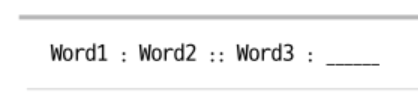

처음 두 단어의 관계와 일치하는 네 번째 단어를 결정하는 것이다. 단어 임베딩을 사용하여 이를 **공간적**으로 인코딩할 수 있다.

먼저 Word1에서 Word2를 뺀다. 뺄셈의 결과로 만들어진 차이 벡터는 Word1와 Word2 사이의 관계를 인코딩한다. 그런 다음 이 차이 벡터를 Word3에 더해 비어있는 네 번째 단어에 가까운 벡터를 생성할 수 있다. 아래의 코드는 벡터 산술 연산과 근사 최근접 이웃 인덱스를 사용해 유추 작업을 수행한다.

In [7]:
class PreTrainedEmbeddings(object):
    """ 사전 훈련된 단어 벡터 사용을 위한 래퍼 클래스 """
    def __init__(self, word_to_index, word_vectors):
        """
        매개변수:
            word_to_index (dict): 단어에서 정수로 매핑
            word_vectors (numpy 배열의 리스트)
        """
        self.word_to_index = word_to_index
        self.word_vectors = word_vectors
        self.index_to_word = {v: k for k, v in self.word_to_index.items()}

        self.index = AnnoyIndex(len(word_vectors[0]), metric='euclidean')
        print("인덱스 만드는 중!")
        for _, i in self.word_to_index.items():
            self.index.add_item(i, self.word_vectors[i])
        self.index.build(50)
        print("완료!")
        
    @classmethod
    def from_embeddings_file(cls, embedding_file):
        """사전 훈련된 벡터 파일에서 객체를 만듭니다.
        
        벡터 파일은 다음과 같은 포맷입니다:
            word0 x0_0 x0_1 x0_2 x0_3 ... x0_N
            word1 x1_0 x1_1 x1_2 x1_3 ... x1_N
        
        매개변수:
            embedding_file (str): 파일 위치
        반환값:
            PretrainedEmbeddings의 인스턴스
        """
        word_to_index = {}
        word_vectors = []

        with open(embedding_file) as fp:
            for line in fp.readlines():
                line = line.split(" ")
                word = line[0]
                vec = np.array([float(x) for x in line[1:]])
                
                word_to_index[word] = len(word_to_index)
                word_vectors.append(vec)
                
        return cls(word_to_index, word_vectors)
    
    def get_embedding(self, word):
        """
        매개변수:
            word (str)
        반환값
            임베딩 (numpy.ndarray)
        """
        return self.word_vectors[self.word_to_index[word]]

    def get_closest_to_vector(self, vector, n=1):
        """벡터가 주어지면 n 개의 최근접 이웃을 반환합니다
        매개변수:
            vector (np.ndarray): Annoy 인덱스에 있는 벡터의 크기와 같아야 합니다
            n (int): 반환될 이웃의 개수
        반환값:
            [str, str, ...]: 주어진 벡터와 가장 가까운 단어
                단어는 거리순으로 정렬되어 있지 않습니다.
        """
        nn_indices = self.index.get_nns_by_vector(vector, n)
        return [self.index_to_word[neighbor] for neighbor in nn_indices]
    
    def compute_and_print_analogy(self, word1, word2, word3):
        """단어 임베딩을 사용한 유추 결과를 출력합니다

        word1이 word2일 때 word3은 __입니다.
        이 메서드는 word1 : word2 :: word3 : word4를 출력합니다
        
        매개변수:
            word1 (str)
            word2 (str)
            word3 (str)
        """
        vec1 = self.get_embedding(word1)
        vec2 = self.get_embedding(word2)
        vec3 = self.get_embedding(word3)

        # 네 번째 단어 임베딩을 계산합니다
        spatial_relationship = vec2 - vec1
        vec4 = vec3 + spatial_relationship

        closest_words = self.get_closest_to_vector(vec4, n=4)
        existing_words = set([word1, word2, word3])
        closest_words = [word for word in closest_words 
                             if word not in existing_words] 

        if len(closest_words) == 0:
            print("계산된 벡터와 가장 가까운 이웃을 찾을 수 없습니다!")
            return
        
        for word4 in closest_words:
            print("{} : {} :: {} : {}".format(word1, word2, word3, word4))

In [11]:
embeddings = PreTrainedEmbeddings.from_embeddings_file('data/glove/glove.6B.100d.txt')

인덱스 만드는 중!
완료!


PreTrainedEmbeddings 클래스에 compute_and_print_analogy(), get_closest_to_vector(), get_embedding()이 추가로 구현되었다.

In [12]:
# 직접 단어를 유추해보자.

# 1. 성별 명사와 대명사의 관계
embeddings.compute_and_print_analogy('man','he','woman')

man : he :: woman : she
man : he :: woman : her


In [13]:
# 2. 동사-명사 관계
embeddings.compute_and_print_analogy('fly','plane','sail')

fly : plane :: sail : ship
fly : plane :: sail : vessel
fly : plane :: sail : boat


In [14]:
# 3. 명사-명사
embeddings.compute_and_print_analogy('cat', 'kitten', 'dog')

cat : kitten :: dog : puppy
cat : kitten :: dog : puppies
cat : kitten :: dog : junkyard


In [16]:
# 4. 상위어(더 넓은 범주)
embeddings.compute_and_print_analogy('blue', 'color', 'dog')

blue : color :: dog : animal
blue : color :: dog : pet
blue : color :: dog : taste
blue : color :: dog : touch


In [18]:
# 5. 부분과 전체 관계
embeddings.compute_and_print_analogy('toe', 'foot', 'finger')

toe : foot :: finger : hand
toe : foot :: finger : kept
toe : foot :: finger : ground


In [20]:
# 6. 방식의 차이
embeddings.compute_and_print_analogy('talk', 'communicate', 'read')

talk : communicate :: read : interpret
talk : communicate :: read : communicated
talk : communicate :: read : transmit


In [21]:
# 7. 전체 의미(관습/인물)
embeddings.compute_and_print_analogy('blue','democrat', 'red') # 파랑, 민주주의자, 빨강 -> 공화주의자

blue : democrat :: red : republican
blue : democrat :: red : congressman
blue : democrat :: red : senator


In [22]:
# 8. 비교급
embeddings.compute_and_print_analogy('fast', 'faster', 'young')

fast : faster :: young : younger
fast : faster :: young : older
fast : faster :: young : youngsters


In [24]:
# 단어 벡터는 동시에 등장하는 정보를 기반으로 하므로 잘못된 관계가 만들어지기도 한다.
embeddings.compute_and_print_analogy('fast', 'fastest', 'small') # 책에서는 largest가 출력됨

fast : fastest :: small : smallest
fast : fastest :: small : largest
fast : fastest :: small : among
fast : fastest :: small : quarters
